# Explicit Newmark-$\beta$

In [152]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

N_refine = 200
# Define mesh
N_mesh = N_refine
l_bar = 10.
mesh = IntervalMesh(N_mesh,0,l_bar)

# =========================================================
# DEFINE BOUNDARY ELEMENTS

tol = 1E-12
# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.,tol) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], l_bar,tol) and on_boundary

def left_and_right(x, on_boundary):
    return on_boundary

# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(left_and_right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)
# =========================================================

# =========================================================
# DEFINE MAT. PROPERTIES

E = Constant(70e3)
nu = Constant(0.3)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
sig0 = Constant((10e2))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus
rho = Constant(10e4)

delta_mur = 1/sig0/sig0
beta_mur = 1/sig0*0.1
r_e = 2*mu*sig0*sig0
tau1 = Constant(0.1)*r_e

Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
T_total = 7
Nincr = N_refine*50*T_total
# Nincr = 100
load_steps = np.linspace(0, T_total, Nincr+1)[1:]

dt = Constant(load_steps[1]-load_steps[0])
dt_ = float(dt)

# Newmark-beta method
betaN = Constant(0.25)
gammaN = Constant(0.5)

# =========================================================

# =========================================================
# DEFINE ELEMENT FUNCTION SPACE AND VARIABLES

deg_u = 3
deg_stress = 1
V = FunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=1, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)
# Define function space for stresses
Vsig = VectorFunctionSpace(mesh, "DG", 0)

sig = Function(W)
sig_old = Function(W)
beta = Function(W0)
beta1 = Function(V)
gamma0 = Function(W0)
gamma0.interpolate(Constant(1e-6))
u = Function(V, name="Total displacement")
g_int = Function(V, name="Internal")
u_d = Function(V)
u_dd = Function(V)

u_pre = Function(V)
u_old = Function(V)
u_d_old = Function(V)
u_dd_old = Function(V)

g_int_old = Function(V)

du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
v_g = TrialFunction(V)
u_ = TestFunction(V)
ug_ = TestFunction(V)

u_theo = Function(V)

sig_out = Function(Vsig, name="sigma")
eps_out = Function(Vsig, name="epsilon")

# metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
# dxm = dx(metadata=metadata)

# =========================================================

als = np.array([2])
results_1dss = np.zeros((Nincr+1, N_mesh,als.size))
results_1dssv = np.zeros((Nincr+1, N_mesh,als.size))
results_1dsg = np.zeros((Nincr+1, N_mesh,als.size))
i_a = 0

for al in als:
    # =========================================================
    # DEFINE NEUMANN BCs 

    pt  = 1./3     # Gaussian width
    t0  = 1./2      # Time shift

    bc_expression = Expression(("t <= tc ? x[0]*q*sin(2*pi/2.4*t) : 0"), q=al, t=0, tc=4.8, degree=deg_u)
    bc = DirichletBC(V, bc_expression, left_and_right)    

    zero = Constant(0.0)
    bc_newton = DirichletBC(V, zero, left_and_right)

    n_face = FacetNormal(mesh)

    q_lim = float(2/sqrt(3)*sig0*mu*2)

    loading = Expression(("t <= tc ? q*sin(2*pi/0.6*t) : 0"), q=2*q_lim, t=0, tc=1.2, degree=deg_u)

    source = Expression(\
        ("0*t")\
        ,t=0, L=l_bar, degree=deg_u)
    # source = Expression(("x[0]<5.01 & x[0]>4.99 ? (t-t0) * exp(-1/pt/pt * (t-t0)*(t-t0)) : 0"),\
    #                            pt=pt, t=0, t0=t0, degree=deg_u)

    def F_ext(v):
        return dot(loading,v)*dss(3)

    def F_ext_u(v,u,g_int):
        return (1-g_int)*dot(dot(sigma(eps(u)),n_face),v)*dss(3)
    # =========================================================

    # =========================================================
    # DEFINE FUNCTIONS FOR FUNCTIONAL CONSTRUCTION

    def eps(v):
        e = 0.5*grad(v)
        return e

    def sigma(eps_el):
        return 2*mu*eps_el*(1 - beta_mur*2*eps_el[0] - delta_mur*(2*eps_el[0])*(2*eps_el[0]) )

    def sigma_out(r):
        return 2.0*mu*sym(grad(r))


    def sigma_tang(e):
        return 2*mu*beta*e
    
    def energy(epsilon):
        # epsilon = 2*e
        W_energy = (0.5 - beta_mur/3*2*epsilon[0] - delta_mur/4*2*epsilon[0]*2*epsilon[0] )*inner(2*epsilon,2*epsilon)
        return W_energy
    # =========================================================

    # =========================================================
    # EXPLICIT NEWMARK-BETA METHOD
    
    a_Newton_g = - tau1*inner(ug_,v_g)*dx
    
    res_g = dt*inner( ( -energy(eps(u_old)) + r_e * g_int_old / (1-g_int_old*g_int_old) ),ug_) *dx \
            + tau1 * inner(ug_,g_int_old)*dx

    a_Newton = rho*inner(u_,v)*dx

    res = - (1-g_int)*inner(2*eps(u_), sigma(eps(u)) )*dx + \
          inner(u_,source)*dx + \
          F_ext_u(u_,u,g_int)

    # FILE OUTPUT
    file_results = XDMFFile("nonlinearElas1DNonIntEXPLI__results.xdmf")
    file_results.parameters["flush_output"] = True
    file_results.parameters["functions_share_mesh"] = True

    # Initial conditions

    # 1 Solve the initial acc.
    u.interpolate( Expression(("0"), degree=2) )
    g_int.interpolate( Expression(("0"), degree=2) )

    A, Res = assemble_system(a_Newton, res) # No BC need to be assigned

    solve(A, u_dd.vector(), Res, "mumps")
    nRes = Res.norm("l2")
    print("    Residual:", nRes," ",0)

    u_old.assign(u)
    u_d_old.interpolate( Expression(("0"), degree=2) )
    u_dd_old.assign(u_dd)
    g_int_old.assign(g_int)

    # 2 Start stepping forward:

    for (i, t) in enumerate(load_steps[0:]):
        # 2.1 Update u_{n+1}, g_{n+1}
        loading.t = t
        bc_expression.t = t
        source.t = t

        u.vector()[:] = u_old.vector() + dt_*u_d_old.vector() + dt_**2/2 * u_dd_old.vector()
        bc.apply(u.vector())
        
        A_g, Res_g = assemble_system(a_Newton_g, res_g) # No BC need to be assigned
        nRes_g = Res_g.norm("l2")
        # print("    G Residual:", nRes_g," ",i+1)

        solve(A_g, g_int.vector(), Res_g, "mumps")
        # print(g_int(9))

        # 2.2 Solve for u_dd_{n+1}
        A, Res = assemble_system(a_Newton, res) # No BC need to be assigned
        nRes = Res.norm("l2")
        # print("    Residual:", nRes," ",i+1)

        solve(A, u_dd.vector(), Res, "mumps")

        # 2.3 Update u_d_{n+1}
        u_d.vector()[:] = u_d_old.vector() + 0.5*dt_*( u_dd_old.vector() + u_dd.vector() )

        # 2.4 Update the old_field
        u_old.assign(u)
        u_d_old.assign(u_d)
        u_dd_old.assign(u_dd)
        g_int_old.assign(g_int)

        file_results.write(u, t)
        for i_x in range(N_mesh):
            results_1dss[i+1,i_x,i_a] = u(l_bar*i_x/(N_mesh-1))
            results_1dssv[i+1,i_x,i_a] = u_d_old(l_bar*i_x/(N_mesh-1))
            results_1dsg[i+1,i_x,i_a] = g_int(l_bar*i_x/(N_mesh-1))
    i_a += 1

    print("Computing completed---------------------------------")


/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


    Residual: 0.0   0
Computing completed---------------------------------


In [28]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

from matplotlib import animation

<IPython.core.display.Javascript object>


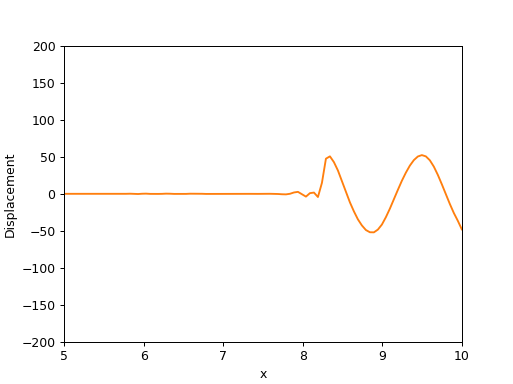

In [163]:
fig, ax = plt.subplots()

line1, = ax.plot([])
line2, = ax.plot([])
line3, = ax.plot([])

ax.set_xlim(5,10)
ax.set_ylim(-0.5e-8,0.5e-8)
# ax.set_ylim(-1e-0,2e-0)
ax.set_ylim(-20e1,20e1)

ax.set_xlabel('x')
ax.set_ylabel('Displacement')

N_d = 10

def animate(frame_num):
    # ax.clear()
    # line1.set_data((np.linspace(0,10,N_mesh), 1e12*results_1dsg[frame_num*N_d, :,0])) # Implicit - direct
    line2.set_data((np.linspace(0,10,N_mesh), results_1dssv[frame_num*N_d, :,0])) # Explicit
    # line3.set_data((np.linspace(0,10,N_mesh), results_1d2[frame_num, :]-0.1)) # Implicit - manual
    return line1, line2#, line3

ani = FuncAnimation(fig, animate, frames=int(Nincr/N_d), interval=1)

# f = r"Waves_nonlin.mp4"
# ani.save(f, writer=animation.FFMpegFileWriter(fps=200))

plt.show()

<IPython.core.display.Javascript object>


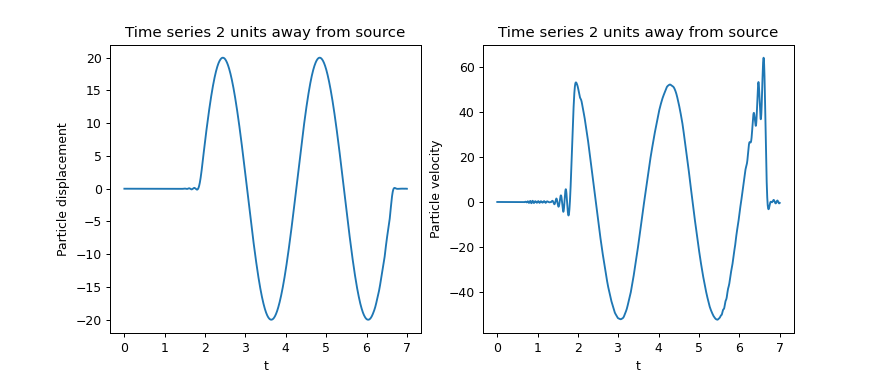

Text(0, 0.5, 'Particle velocity')

In [172]:
fri_d = 0.9

plt.subplots()
plt.subplot(1,2,1)
#plt.plot(load_steps,results_1dsg[1:,int(fri_d*N_mesh),0])
plt.plot(load_steps,results_1dss[1:,int(fri_d*N_mesh),0])
# plt.plot(load_steps,results_1dss[1:,int(fri_d*N_mesh),1])
# plt.plot(load_steps,results_1dsg[1:,int(fri_d*N_mesh),2])
# plt.plot(load_steps,results_1dsg[1:,int(fri_d*N_mesh),3])
# plt.plot(load_steps,np.zeros((load_steps.size,1)),'k--')

plt.title('Time series 2 units away from source')
plt.xlabel('t')
plt.ylabel('Particle displacement')

plt.subplot(1,2,2)
#plt.plot(load_steps,results_1dsg[1:,int(fri_d*N_mesh),0])
plt.plot(load_steps,results_1dssv[1:,int(fri_d*N_mesh),0])
# plt.plot(load_steps,results_1dss[1:,int(fri_d*N_mesh),1])
# plt.plot(load_steps,results_1dsg[1:,int(fri_d*N_mesh),2])
# plt.plot(load_steps,results_1dsg[1:,int(fri_d*N_mesh),3])
# plt.plot(load_steps,np.zeros((load_steps.size,1)),'k--')

plt.title('Time series 2 units away from source')
plt.xlabel('t')
plt.ylabel('Particle velocity')
# plt.xlim([2,6])